In [1]:
import pandas as pd
from tslearn.utils import load_time_series_txt

Read time series and labels of cpu.

In [2]:
new_ts = load_time_series_txt('../data/amazon/NEW_ts_1y.txt')
labels = pd.read_csv('../data/amazon/NEW_label_1y.txt', header=None, names=['label'])
labels.head()

,label
0,cpu Intel core i9-10940X
1,cpu Intel core i9-10920X
2,cpu Intel core i9-10900X
3,cpu Intel core i9-10900K
4,cpu Intel core i9-10900KF


Define a special transformer to normalize data.

In [3]:
import numpy as np
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMinMax

class TimeSeriesScalerZeroMax(TimeSeriesScalerMinMax):
    def __init__(self, value_range=(0., 1)):
        super().__init__(value_range=value_range)

    def fit(self, X, y=None, **kwargs):
        return super().fit(X)

    def fit_transform(self, X, y=None, **kwargs):
         return self.fit(X).transform(X)

    def transform(self, X, y=None, **kwargs):
        value_range = self.value_range
        max_t = np.nanmax(X, axis=1)[:, np.newaxis]
        range_t = max_t
        range_t[range_t == 0.] = 1.
        X_ = X * (value_range[1] - value_range[0]) / range_t + value_range[0]
        X_[X == -1] = -1
        X_ = to_time_series_dataset(X_)
        return X_

Do transformation on the data set.

In [4]:
X = TimeSeriesScalerZeroMax().fit_transform(new_ts)

Use TimeSeriesKMeans with dtw to cluster our time series.

In [5]:
import time

t = time.time()
from tslearn.clustering import TimeSeriesKMeans
km = TimeSeriesKMeans(n_clusters=10, metric="dtw", random_state=501, max_iter=5, n_jobs=-1)
y_pred = km.fit_predict(X)
print(f'Finish training, time elapsed: {time.time() - t:.2f}s.')

Finish training, time elapsed: 83.44s.


Write functions to plot by clusters and show the labels in each cluster.

In [6]:
from matplotlib import pyplot as plt

def plot_kmeans(km_model, X_pred, y_pred, show_center=True):
    plt.figure(figsize=(10, 2 * km_model.n_clusters))
    for yi in range(km_model.n_clusters):
        plt.subplot(km_model.n_clusters // 2, 2, yi + 1)
        for xx in X_pred[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        if show_center:
            plt.plot(km_model.cluster_centers_[yi].ravel(), "r-")
        plt.ylim(-0.2, 1.2)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)
        if yi == 0:
            plt.title("DBA $k$-means")

def show_labels(km_model, y_pred, y_labels):
    label_by_cluster = [[] for _ in range(km_model.n_clusters)]
    for idx, label in enumerate(y_pred):
        label_by_cluster[label].append(y_labels.values[idx])
    for idx, ls in enumerate(label_by_cluster):
        print(f'Cluster {idx + 1}: ')
        def print_category(catagory):
            cata_labels = [l for l in ls if l.startswith(catagory)]
            if not cata_labels: return
            print(f'\t{len(cata_labels)} {catagory}: ', ', '.join(cata_labels))
        print_category('cpu')
        print_category('gpu')
        print_category('drive')

Test two functions.

Cluster 1: 
	1 cpu:  cpu AMD ryzen 3 3100
	13 gpu:  gpu MSI NVIDIA Geforce RTX 2060 Super, gpu MSI NVIDIA Geforce RTX 2070, gpu MSI NVIDIA Geforce RTX 2080 Super, gpu MSI AMD Radeon RX 5600 XT, gpu EVGA NVIDIA Geforce RTX 2060, gpu Sapphire Technology AMD Radeon RX 5500 XT, gpu Sapphire Technology AMD Radeon RX 5500 XT, gpu Sapphire Technology AMD Radeon RX 5700 XT, gpu Sapphire Technology AMD Radeon RX 5700 XT, gpu Gigabyte NVIDIA Geforce RTX 2080 Super, gpu ZOTAC NVIDIA Geforce GTX 1660, gpu ZOTAC NVIDIA Geforce RTX 2060 Super, gpu ZOTAC NVIDIA Geforce RTX 2070 Super
	1 drive:  drive Seagate skyhawk ai 35 12tb
Cluster 2: 
	4 cpu:  cpu Intel core i9-10900KF, cpu Intel core i9-9900K, cpu Intel core i7-10700KF, cpu Intel core i5-10600K
	8 drive:  drive Kingston kc2500 nvme 512gb, drive Kingston kc2500 nvme 1tb, drive Kingston kc2500 nvme 2tb, drive SAMSUNG 870 qvo sata 2tb, drive Seagate barracuda 510 nvme 256gb, drive SK hynix gold s31 sata 512gb, drive Western Digital wd red 35 3tb, d

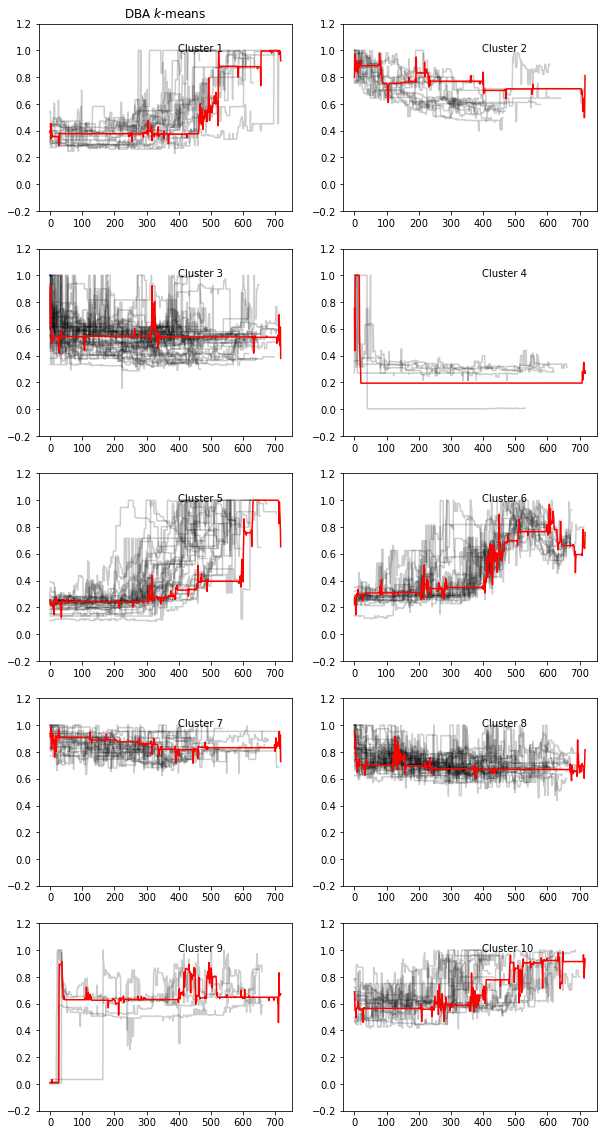

In [7]:
plot_kmeans(km, X, y_pred)
show_labels(km, y_pred, labels['label'])

The cluster 1, 5, 6 are pretty good! Both clusters mainly contain graphic cards and show the huge increment in prices.

Let's try another metric.

In [8]:
from numpy import VisibleDeprecationWarning
import warnings
t = time.time()
warnings.filterwarnings("ignore", category=VisibleDeprecationWarning)
kms = TimeSeriesKMeans(n_clusters=10, metric='softdtw', random_state=501, max_iter=5, n_jobs=-1)
y_pred1 = kms.fit_predict(X)
print(f'Finish training, time elapsed: {time.time() - t:.2f}s.')

Finish training, time elapsed: 575.36s.


Cluster 1: 
	7 cpu:  cpu Intel core i9-10940X, cpu Intel core i9-10920X, cpu Intel core i9-10900K, cpu Intel core i9-10900, cpu Intel core i9-10900F, cpu Intel core i7-10700K, cpu AMD ryzen 9 3950X
	1 gpu:  gpu EVGA NVIDIA Geforce GTX 1660 Ti
	13 drive:  drive SanDisk ssd plus sata 2tb, drive SanDisk ultra 3d nand sata 4tb, drive Seagate barracuda 120 sata 2tb, drive Seagate barracuda 510 nvme 1tb, drive Western Digital wd gold sata 1tb, drive Western Digital wd gold sata 4tb, drive Western Digital wd red sata 512gb, drive Western Digital wd red sata 2tb, drive Western Digital wd red m2 2tb, drive Seagate skyhawk ai 35 16tb, drive WD_BLACK wd black 35 8tb, drive Western Digital wd gold 35 4tb, drive Western Digital wd gold 35 16tb
Cluster 2: 
	1 cpu:  cpu AMD ryzen 5 3600XT
	2 gpu:  gpu ZOTAC NVIDIA Geforce RTX 2070, gpu ZOTAC NVIDIA Geforce RTX 2080
	4 drive:  drive ADATA su720 sata 1tb, drive Seagate barracuda q1 sata 1tb, drive Seagate ironwolf 35 6tb, drive Seagate ironwolf pro 35 

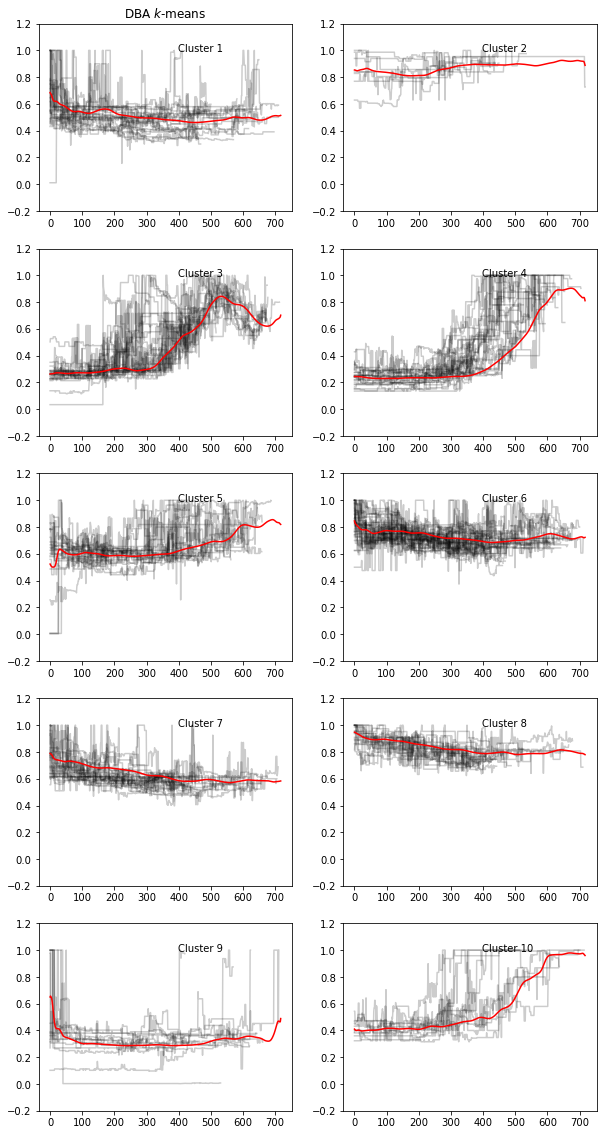

In [9]:
plot_kmeans(kms, X, y_pred1)
show_labels(kms, y_pred1, labels['label'])

It takes 10 times longer to fit a softdtw model but the cluster centers are much better.
Let's try another data set.

In [17]:
new_ts1 = load_time_series_txt('../data/amazon/NEW_ts_6m.txt')
labels1 = pd.read_csv('../data/amazon/NEW_label_6m.txt', header=None, names=['label'])
X1 = TimeSeriesScalerZeroMax().fit_transform(new_ts1)

Cluster again and show the result.

In [18]:
t = time.time()
kms1 = TimeSeriesKMeans(n_clusters=10, metric='softdtw', random_state=501, max_iter=5, n_jobs=-1)
y_pred1 = kms1.fit_predict(X1)
print(f'Finish training, time elapsed: {time.time() - t:.2f}s.')

Finish training, time elapsed: 56.39s.


Cluster 1: 
	1 cpu:  cpu Intel core i5-10600KF
	3 gpu:  gpu ASUS NVIDIA Geforce RTX 3060, gpu XFX AMD Radeon RX 6900 XT, gpu Gigabyte NVIDIA Geforce RTX 3060
	5 drive:  drive SAMSUNG 980 pro nvme 1tb, drive Seagate barracuda q5 nvme 2tb, drive WD_BLACK sn850 nvme 1tb, drive Western Digital wd red pro 35 16tb, drive Western Digital wd red pro 35 18tb
Cluster 2: 
	4 gpu:  gpu Sapphire Technology AMD Radeon RX 570, gpu Sapphire Technology AMD Radeon RX 6800 XT, gpu Gigabyte NVIDIA Geforce RTX 2070, gpu Gigabyte NVIDIA Geforce RTX 3090
Cluster 3: 
	3 cpu:  cpu AMD ryzen 9 5950X, cpu AMD ryzen 9 5900X, cpu AMD ryzen 7 5800X
	1 gpu:  gpu MSI AMD Radeon RX 6800 XT
	1 drive:  drive WD_BLACK an1500 nvme 4tb
Cluster 4: 
	7 gpu:  gpu MSI NVIDIA Geforce RTX 3070, gpu ASUS NVIDIA Geforce RTX 3070, gpu ASUS AMD Radeon RX 6900 XT, gpu ASUS AMD Radeon RX 6900 XT, gpu Sapphire Technology AMD Radeon RX 6900 XT, gpu Gigabyte AMD Radeon RX 6800, gpu ZOTAC NVIDIA Geforce RTX 2080
	2 drive:  drive WD_BLACK 

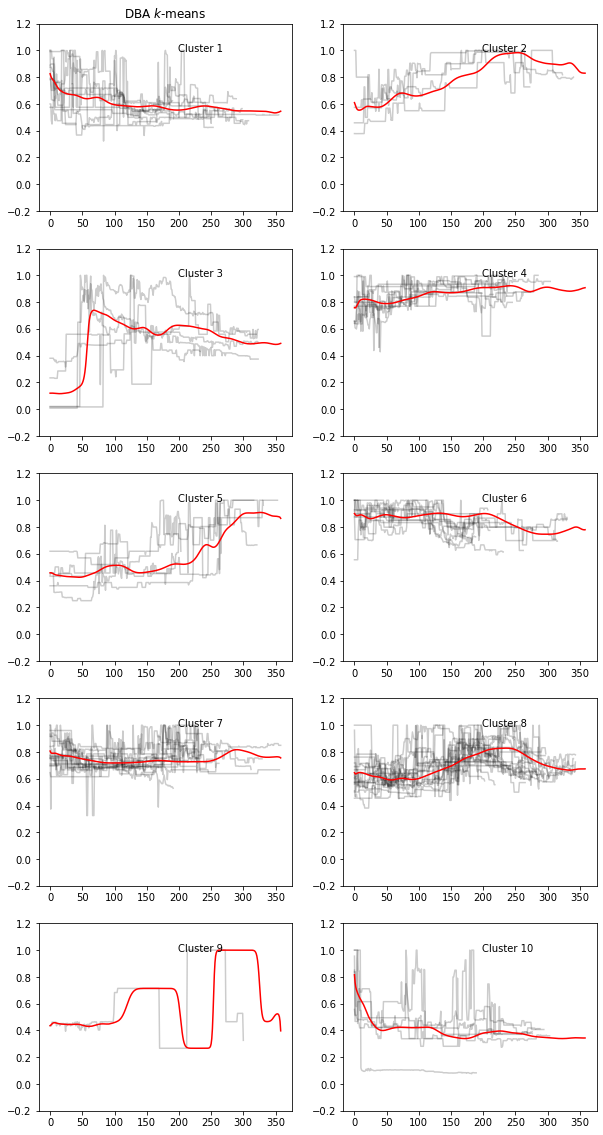

In [19]:
plot_kmeans(kms1, X1, y_pred1)
show_labels(kms1, y_pred1, labels1['label'])